In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (12, 6)
import pandas as pd
import random 
import seaborn as sns
import time 

# For consistent random
random.seed(123)

## 1. Basic implementation of neural network trained using back-propagation (15 points)

### Activation Functions & Corresponding Deriavtives 

Rectified Linear Unit (RELU) Activation Function
\begin{equation}
f(x)=max(0,x)
\end{equation}
Derivative of ReLU
\begin{equation}
    f(x)= 
\begin{cases}
    1,&  x > 0\\
    0,              & \text{otherwise}
\end{cases}
\end{equation}

Sigmoid Activation Function 
\begin{equation}
f(x) = \sigma (x) = \frac{1}{1 + e^{-x}}
\end{equation}
Derivative of Sigmoid
\begin{equation}
f\prime(x) = \sigma (x) (1 - \sigma (x))
\end{equation}

Tangent Hyperbolic Activation Function
\begin{equation}
f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
\end{equation}

Derivative of Tangent Hyperbolic
\begin{equation}
f\prime(x) = 1 - (f(x))^2
\end{equation}

In [2]:
def relu(x, derivative=False):
    if derivative:
        return np.array(x >= 0).astype('int')
    return np.maximum(x, 0)

def sigmoid(x, derivative=False):
    if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.square(np.tanh(x))
    return np.tanh(x)

def softmax(x, derivative=False):
    exps = np.exp(x - x.max())
    if derivative:
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    return exps / np.sum(exps, axis=0)

### Random Weights Initialization

In [3]:
def initialize_params(layer_sizes):
    params = {}
    for i in range(1, len(layer_sizes)):
        params['W' + str(i)] = np.random.randn(layer_sizes[i], layer_sizes[i-1])*0.01
        params['B' + str(i)] = np.random.randn(layer_sizes[i],1)*0.01
    return params

The Nueral Network Weights are initialized using:
- `np.random.randn(layer_sizes[i], layer_sizes[i-1])*0.01`
- `np.random.randn(layer_sizes[i],1)*0.01`

The distribution plot below shows the range of values the initial weights take for a neural network with the following weights:
- `Layer_sizes = [13, 5, 5, 1]`
- 13 Inputs in the input layer
- 2 Hidden Layers with 5 neurons
- 1 Output layer

In [4]:
layer_sizes_nn = [13, 5, 5, 1]
W_parameter = np.random.randn(layer_sizes_nn[1], layer_sizes_nn[1-1])*0.01
B_parameter = np.random.randn(layer_sizes_nn[1],1)*0.01

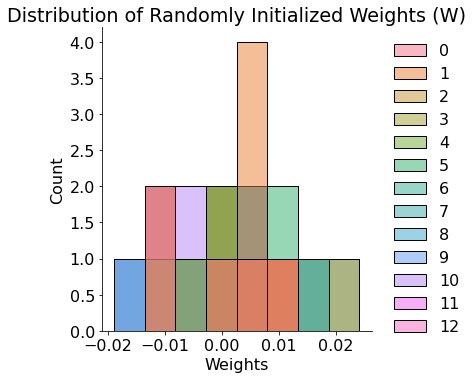

In [5]:
sns.displot(W_parameter);
plt.title("Distribution of Randomly Initialized Weights (W)");
plt.xlabel("Weights");

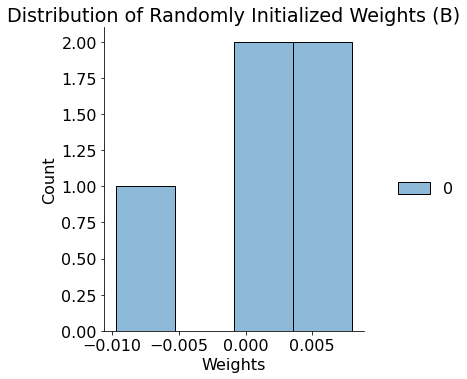

In [6]:
sns.displot(B_parameter);
plt.title("Distribution of Randomly Initialized Weights (B)");
plt.xlabel("Weights");

### Forward Propagation

In [7]:
def forward_propagation(X_train, params):
    layers = len(params)//2
    values = {}
    for i in range(1, layers+1):
        if i==1:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], X_train) + params['B' + str(i)]
            # Relu Activation function
            values['A' + str(i)] = relu(values['Z' + str(i)])
        else:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], values['A' + str(i-1)]) + params['B' + str(i)]
            if i==layers:
                values['A' + str(i)] = values['Z' + str(i)]
            else:
                # Relu Activation Function
                values['A' + str(i)] = relu(values['Z' + str(i)])
    return values

### Cost Computation

\begin{equation}
J = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y} - y)^2
\end{equation}

In [8]:
def compute_cost(values, Y_train):
    layers = len(values)//2
    Y_pred = values['A' + str(layers)]
    cost = 1/(2*len(Y_train)) * np.sum(np.square(Y_pred - Y_train))
    return cost

### Backward Propagation

In [9]:
def backward_propagation(params, values, X_train, Y_train):
    layers = len(params)//2
    m = len(Y_train)
    grads = {}
    for i in range(layers,0,-1):
        if i==layers:
            dA = 1/m * (values['A' + str(i)] - Y_train)
            dZ = dA
        else:
            dA = np.dot(params['W' + str(i+1)].T, dZ)
            # Derivative of ReLU 
            dZ = np.multiply(dA, relu(values['A' + str(i)], derivative=True))
        if i==1:
            grads['W' + str(i)] = 1/m * np.dot(dZ, X_train.T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        else:
            grads['W' + str(i)] = 1/m * np.dot(dZ,values['A' + str(i-1)].T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    return grads

### Neural Netwrok Parameter Update 

In [10]:
def update_params(params, grads, learning_rate):
    layers = len(params)//2
    params_updated = {}
    for i in range(1,layers+1):
        params_updated['W' + str(i)] = params['W' + str(i)] - learning_rate * grads['W' + str(i)]
        params_updated['B' + str(i)] = params['B' + str(i)] - learning_rate * grads['B' + str(i)]
    return params_updated

### Neural Network Model Training

In [11]:
def model(X_train, Y_train, layer_sizes, num_iters, learning_rate):
    model_iteration = []
    model_cost = []
    params = initialize_params(layer_sizes)
    for i in range(num_iters):
        values = forward_propagation(X_train.T, params)
        cost = compute_cost(values, Y_train.T)
        grads = backward_propagation(params, values,X_train.T, Y_train.T)
        params = update_params(params, grads, learning_rate)
        model_iteration.append(i+1)
        model_cost.append(cost)
    return params, model_iteration, model_cost

### Neural Network Performance

In [12]:
def compute_accuracy(X_train, X_test, Y_train, Y_test, params):
    values_train = forward_propagation(X_train.T, params)
    values_test = forward_propagation(X_test.T, params)
    train_acc = np.sqrt(mean_squared_error(Y_train, values_train['A' + str(len(layer_sizes)-1)].T))
    test_acc = np.sqrt(mean_squared_error(Y_test, values_test['A' + str(len(layer_sizes)-1)].T))
    return train_acc, test_acc

### Neural Network Output Predictions

In [13]:
def predict(X, params):
    values = forward_propagation(X.T, params)
    predictions = values['A' + str(len(values)//2)].T
    return predictions

### Dataset 

In [88]:
data = load_boston()
df = df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data["target"] 

In [89]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- `CRIM` - per capita crime rate by town
- `ZN` - proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS` - proportion of non-retail business acres per town.
- `CHAS` - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- `NOX` - nitric oxides concentration (parts per 10 million)
- `RM` - average number of rooms per dwelling
- `AGE` - proportion of owner-occupied units built prior to 1940
- `DIS` - weighted distances to five Boston employment centres
- `RAD` - index of accessibility to radial highways
- `TAX` - full-value property-tax rate per \$10,000
- `PTRATIO` - pupil-teacher ratio by town
- `B` - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- `LSTAT` - % lower status of the population
- `MEDV` - Median value of owner-occupied homes in \$1000's

Target variable is `MEDV`

### Train-Test Split 

In [17]:
X,y = data["data"], data["target"] 
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size = 0.2)

### Regression Neural Network with ReLU Activation function

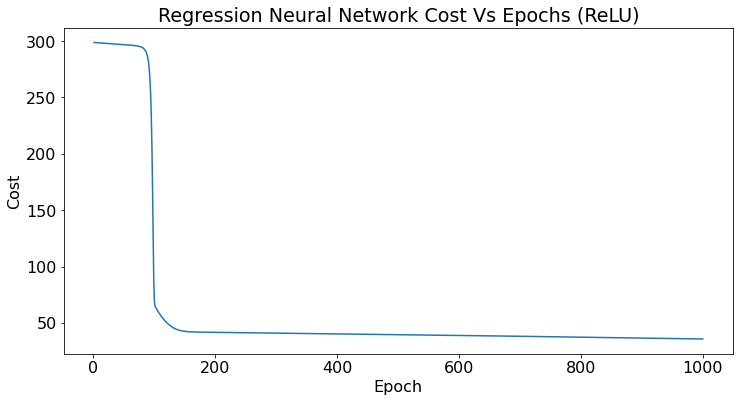

In [25]:
nn_model = model(X_train, Y_train,
                layer_sizes = [13, 8, 8, 1],
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
plt.plot(nn_epochs, nn_cost);
plt.xlabel("Epoch");
plt.ylabel("Cost");
plt.title("Regression Neural Network Cost Vs Epochs (ReLU)");

The regression neural network converged at an epoch approximately close to 200, with a steep decrease in cost

## 2. Exploring the effect of different activation functions (eg. linear, sigmoid, tanh and ReLU) (10 points)

### ReLU Activation Function 

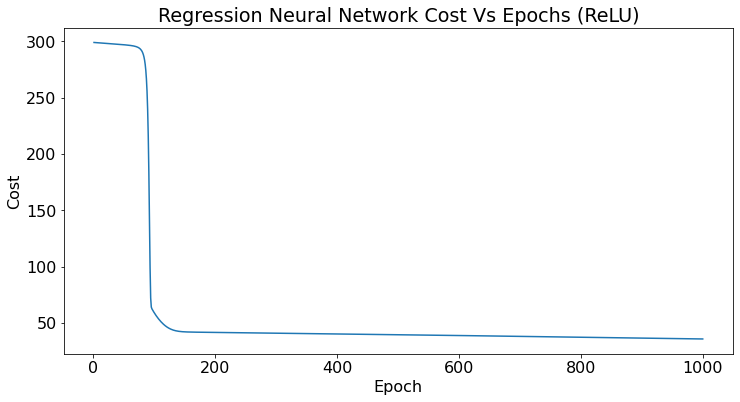

In [37]:
nn_model = model(X_train, Y_train,
                layer_sizes = [13, 8, 8, 1],
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
plt.plot(nn_epochs, nn_cost);
plt.xlabel("Epoch");
plt.ylabel("Cost");
plt.title("Regression Neural Network Cost Vs Epochs (ReLU)");

The regression neural network converged at an epoch approximately close to 200, with a steep decrease in cost 

### Sigmoid Activation Function

The programmed neural network will be updated to use Sigmoid 

In [38]:
def forward_propagation_sigmoid_af(X_train, params):
    layers = len(params)//2
    values = {}
    for i in range(1, layers+1):
        if i==1:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], X_train) + params['B' + str(i)]
            # Sigmoid Activation function
            values['A' + str(i)] = sigmoid(values['Z' + str(i)])
        else:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], values['A' + str(i-1)]) + params['B' + str(i)]
            if i==layers:
                values['A' + str(i)] = values['Z' + str(i)]
            else:
                # Sigmoid Activation Function
                values['A' + str(i)] = sigmoid(values['Z' + str(i)])
    return values

def backward_propagation_sigmoid_af(params, values, X_train, Y_train):
    layers = len(params)//2
    m = len(Y_train)
    grads = {}
    for i in range(layers,0,-1):
        if i==layers:
            dA = 1/m * (values['A' + str(i)] - Y_train)
            dZ = dA
        else:
            dA = np.dot(params['W' + str(i+1)].T, dZ)
            # Derivative of Sigmoid
            dZ = np.multiply(dA, sigmoid(values['A' + str(i)], derivative=True))
        if i==1:
            grads['W' + str(i)] = 1/m * np.dot(dZ, X_train.T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        else:
            grads['W' + str(i)] = 1/m * np.dot(dZ,values['A' + str(i-1)].T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    return grads

def model_sigmoid_af(X_train, Y_train, layer_sizes, num_iters, learning_rate):
    model_iteration = []
    model_cost = []
    params = initialize_params(layer_sizes)
    for i in range(num_iters):
        values = forward_propagation_sigmoid_af(X_train.T, params)
        cost = compute_cost(values, Y_train.T)
        grads = backward_propagation_sigmoid_af(params, values,X_train.T, Y_train.T)
        params = update_params(params, grads, learning_rate)
        model_iteration.append(i+1)
        model_cost.append(cost)
    return params, model_iteration, model_cost

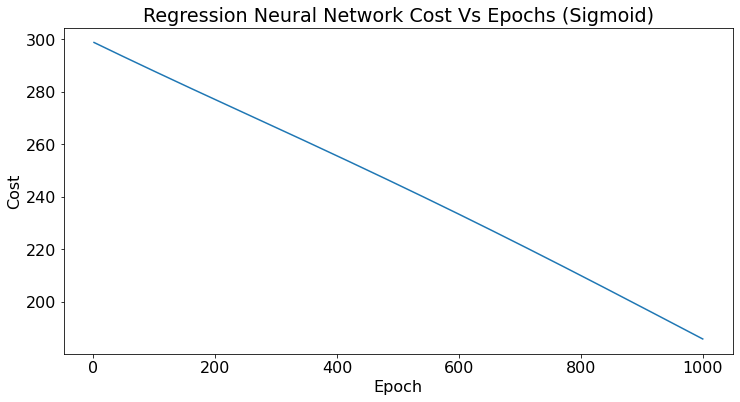

In [41]:
nn_model_sigmoid = model_sigmoid_af(X_train, Y_train,
                layer_sizes = [13, 8, 8, 1],
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters_sigmoid, nn_epochs_sigmoid, nn_cost_sigmoid = nn_model_sigmoid
plt.plot(nn_epochs_sigmoid, nn_cost_sigmoid);
plt.xlabel("Epoch");
plt.ylabel("Cost");
plt.title("Regression Neural Network Cost Vs Epochs (Sigmoid)");

The regression neural network has not converged, however the cost does decrease gradually 

### Tangent Hyperbolic Activation Function

In [40]:
def forward_propagation_tanh_af(X_train, params):
    layers = len(params)//2
    values = {}
    for i in range(1, layers+1):
        if i==1:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], X_train) + params['B' + str(i)]
            # tanh Activation function
            values['A' + str(i)] = tanh(values['Z' + str(i)])
        else:
            values['Z' + str(i)] = np.dot(params['W' + str(i)], values['A' + str(i-1)]) + params['B' + str(i)]
            if i==layers:
                values['A' + str(i)] = values['Z' + str(i)]
            else:
                # Sigmoid Activation Function
                values['A' + str(i)] = tanh(values['Z' + str(i)])
    return values

def backward_propagation_tanh_af(params, values, X_train, Y_train):
    layers = len(params)//2
    m = len(Y_train)
    grads = {}
    for i in range(layers,0,-1):
        if i==layers:
            dA = 1/m * (values['A' + str(i)] - Y_train)
            dZ = dA
        else:
            dA = np.dot(params['W' + str(i+1)].T, dZ)
            # Derivative of tanh
            dZ = np.multiply(dA, tanh(values['A' + str(i)], derivative=True))
        if i==1:
            grads['W' + str(i)] = 1/m * np.dot(dZ, X_train.T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        else:
            grads['W' + str(i)] = 1/m * np.dot(dZ,values['A' + str(i-1)].T)
            grads['B' + str(i)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    return grads

def model_tanh_af(X_train, Y_train, layer_sizes, num_iters, learning_rate):
    model_iteration = []
    model_cost = []
    params = initialize_params(layer_sizes)
    for i in range(num_iters):
        values = forward_propagation_tanh_af(X_train.T, params)
        cost = compute_cost(values, Y_train.T)
        grads = backward_propagation_tanh_af(params, values,X_train.T, Y_train.T)
        params = update_params(params, grads, learning_rate)
        model_iteration.append(i+1)
        model_cost.append(cost)
    return params, model_iteration, model_cost

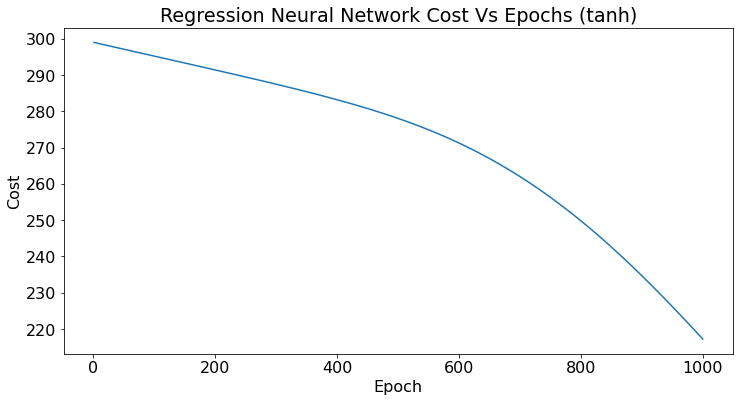

In [42]:
nn_model_tanh = model_tanh_af(X_train, Y_train,
                layer_sizes = [13, 8, 8, 1],
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters_tanh, nn_epochs_tanh, nn_cost_tanh = nn_model_tanh
plt.plot(nn_epochs_tanh, nn_cost_tanh);
plt.xlabel("Epoch");
plt.ylabel("Cost");
plt.title("Regression Neural Network Cost Vs Epochs (tanh)");

The regression neural network has not converged, however the cost does decrease gradually

#### Exploring the effect of different activation functions interpretation:
In the three activation function exploration `(ReLU, Sigmoid, Tanh)`, `ReLU` is shown to be highly trainable, as it decreases the cost function much more quickly as compared to `Sigmoid` and `Tanh` 

## Exploring the effect of network size on generalizability (eg. number of hidden layers, number of hidden neurons) (10 points)


The neural network generalizability will be explored using the `ReLU` activation function, as it shows better model outputs (cost function reduction and convergence) in comparison to `Sigmoid` and `Tanh` for the dataset used

Since generalizability of the model can be measured by how well a model performs on unseen data, the effect of network size on generalizability will be checked according model performance, that is the correctness of the predictions when given unseen data. Inline with the neural network model evaluation metric `RMSE`, a lack of `generalizability` can be seen if the `Test Data RMSE` is significantly higher than `Train Data RMSE`

`Root Mean Square Error (RMSE)` is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are

Given the descriptive analysis of the target below, a good `RMSE` will be a value inbetween 5-12 for this given dataset problem

[Source](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)

In [74]:
arr = data['target']
mean = np.mean(arr)
median = np.median(arr)
 
# measures of dispersion
min = np.amin(arr)
max = np.amax(arr)
range = np.ptp(arr)
variance = np.var(arr)
sd = np.std(arr)
 
print("Descriptive analysis of target")
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min)
print("Maximum =", max)
print("Range =", range)
print("Variance =", variance)
print("Standard Deviation =", sd)

Descriptive analysis
Measures of Central Tendency
Mean = 22.532806324110677
Median = 21.2
Measures of Dispersion
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 84.41955615616556
Standard Deviation = 9.188011545278203


### 2 Hidden layers with 1 neuron at each layer

In [63]:
layer_sizes = [13, 1, 1, 1]
start = time.time()
nn_model = model(X_train, Y_train,
                layer_sizes = layer_sizes,
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
train_rmse_1, test_rmse_1 = compute_accuracy(X_train, X_test, Y_train, Y_test, nn_parameters)
end = time.time()
print('Root Mean Squared Error on Training Data = ' + str(train_rmse_1))
print('Root Mean Squared Error on Test Data = ' + str(test_rmse_1))
print('Execution Time:', end - start)

Root Mean Squared Error on Training Data = 8.734191413979739
Root Mean Squared Error on Test Data = 7.696665033346352
Execution Time: 0.09867405891418457


### 2 Hidden layers with 10 neurons at each layer

In [64]:
layer_sizes = [13, 10,10, 1]
start = time.time()
nn_model = model(X_train, Y_train,
                layer_sizes = layer_sizes,
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
train_rmse_2, test_rmse_2 = compute_accuracy(X_train, X_test, Y_train, Y_test, nn_parameters)
end = time.time()
print('Root Mean Squared Error on Training Data = ' + str(train_rmse_2))
print('Root Mean Squared Error on Test Data = ' + str(test_rmse_2))
print('Execution Time:', end - start)

Root Mean Squared Error on Training Data = 8.463548962992173
Root Mean Squared Error on Test Data = 7.441773611033629
Execution Time: 0.16221261024475098


### 2 Hidden layers with 100 neurons at each layer

In [65]:
layer_sizes = [13, 100,100, 1]
start = time.time()
nn_model = model(X_train, Y_train,
                layer_sizes = layer_sizes,
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
train_rmse_3, test_rmse_3 = compute_accuracy(X_train, X_test, Y_train, Y_test, nn_parameters)
end = time.time()
print('Root Mean Squared Error on Training Data = ' + str(train_rmse_3))
print('Root Mean Squared Error on Test Data = ' + str(test_rmse_3))
print('Execution Time:', end - start)

Root Mean Squared Error on Training Data = 8.626019012068419
Root Mean Squared Error on Test Data = 7.423037824387786
Execution Time: 1.3595359325408936


### 2 Hidden layers with 256 neurons at each layer

In [66]:
layer_sizes = [13, 256,256, 1]
start = time.time()
nn_model = model(X_train, Y_train,
                layer_sizes = layer_sizes,
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
end = time.time()
train_rmse_4, test_rmse_4 = compute_accuracy(X_train, X_test, Y_train, Y_test, nn_parameters)
print('Root Mean Squared Error on Training Data = ' + str(train_rmse_4))
print('Root Mean Squared Error on Test Data = ' + str(test_rmse_4))
print('Execution Time:', end - start)

Root Mean Squared Error on Training Data = 8.533013633795203
Root Mean Squared Error on Test Data = 7.313936018491179
Execution Time: 7.290606260299683


### 2 Hidden layers with 2560 neurons at each layer

In [60]:
layer_sizes = [13, 2560,2560, 1]
start = time.time()
nn_model = model(X_train, Y_train,
                layer_sizes = layer_sizes,
                num_iters = 1000,
                learning_rate = 0.03)
nn_parameters, nn_epochs, nn_cost = nn_model
train_rmse_5, test_rmse_5 = compute_accuracy(X_train, X_test, Y_train, Y_test, nn_parameters)
end = time.time()
print('Root Mean Squared Error on Training Data = ' + str(train_rmse_5))
print('Root Mean Squared Error on Test Data = ' + str(test_rmse_5))
print('Execution Time:', end - start)

Root Mean Squared Error on Training Data = 7.953165766982794
Root Mean Squared Error on Test Data = 6.40323933760832
Execution Time: 408.8188807964325


In [67]:
# Data frame to contain Neural Network Generalizability Information
nn_general_df = pd.DataFrame({
    '2_hidden_layer': ['1Ns', '10Ns', '100Ns', '256Ns', '2560Ns'],
    'Train_data_rmse': [train_rmse_1, train_rmse_2, train_rmse_3, 
                        train_rmse_4, train_rmse_5],
    'Test_data_rmse': [test_rmse_1, test_rmse_2, test_rmse_3, 
                       test_rmse_4, test_rmse_5]
})

In [68]:
nn_general_df

,2_hidden_layer,Train_data_rmse,Test_data_rmse
0,1Ns,8.734191,7.696665
1,10Ns,8.463549,7.441774
2,100Ns,8.626019,7.423038
3,256Ns,8.533014,7.313936
4,2560Ns,7.953166,6.403239


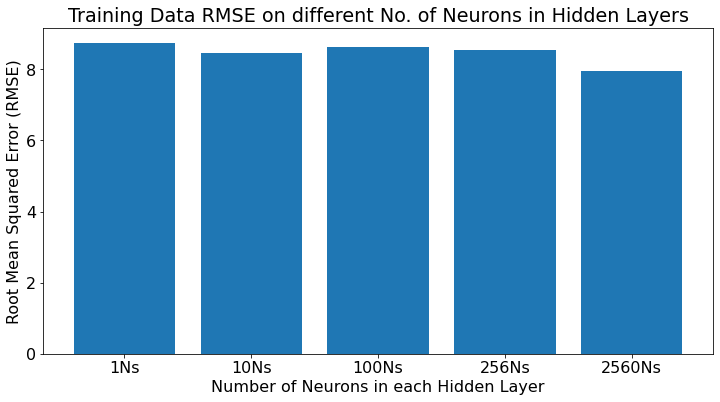

In [69]:
plt.bar(nn_general_df['2_hidden_layer'], nn_general_df['Train_data_rmse']);
plt.xlabel("Number of Neurons in each Hidden Layer");
plt.ylabel("Root Mean Squared Error (RMSE)");
plt.title("Training Data RMSE on different No. of Neurons in Hidden Layers");
plt.show()

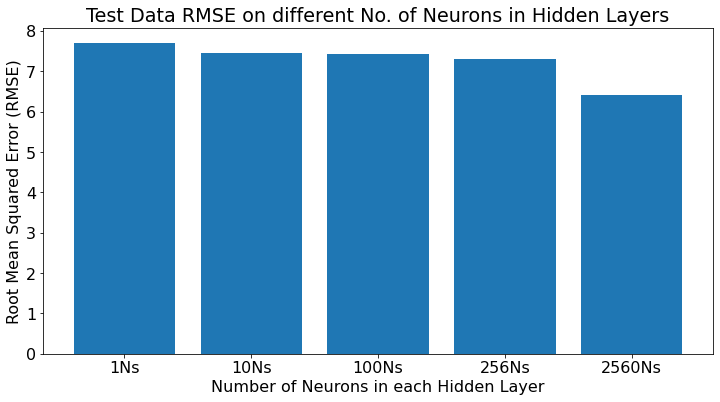

In [70]:
plt.bar(nn_general_df['2_hidden_layer'], nn_general_df['Test_data_rmse']);
plt.xlabel("Number of Neurons in each Hidden Layer");
plt.ylabel("Root Mean Squared Error (RMSE)");
plt.title("Test Data RMSE on different No. of Neurons in Hidden Layers");
plt.show()

Minor changes in network size does not have much of an effect on generalizability, however major changes in network size does have an effect on generalizability (a noticable minor effect). As shown above, a decrease in root mean squared error is visible by changing the number of neurons in each hidden layer to 2560 (Ns-neurons). In comparison to other values in the test data rmse and train data rmse, a better generalizability is shown. 

[Information Source](https://towardsdatascience.com/an-introduction-to-neural-networks-with-implementation-from-scratch-using-python-da4b6a45c05b)